In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import pickle
import glob
import json
from tqdm import trange, tqdm
import numpy as np
import pandas as pd
import tikzplotlib
import matplotlib.pyplot as plt
import shap
shap.initjs()
from sklearn.metrics import roc_curve, auc
from features import merge_entries
from utills import chunker, cartesian_product
import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA_DIR = '../data/pan/'
GROUND_TRUTH_PATH = DATA_DIR + 'pan20-authorship-verification-training-large-truth.jsonl'
DATA_PATH = DATA_DIR + 'pan20-authorship-verification-training-large.jsonl'
PREPROCESSED_DATA_PATH = '../temp_data/pan/'
# TEMP_DATA_PATH = '../temp_data/pan/'
FIGURES_PATH = '../figures/'
COMPUTED_DATA_PATH = '../temp_data/gpt3/'

In [6]:
with open(PREPROCESSED_DATA_PATH + 'experiment_data.p', 'rb') as f:
    (
        aucs,
        clf,
        roc_auc,
        transformer, 
        scaler,
        secondary_scaler,
        feature_sz,
        train_sz,
        train_idxs,
        test_sz,
        test_idxs
    ) = pickle.load(f)
    
fnames = np.array(transformer.get_feature_names())
XX_train = np.memmap(PREPROCESSED_DATA_PATH + 'vectorized_XX_train.npy', dtype='float32', mode='r', shape=(train_sz, feature_sz))
XX_test = np.memmap(PREPROCESSED_DATA_PATH + 'vectorized_XX_test.npy', dtype='float32', mode='r', shape=(test_sz, feature_sz))
XX_train_sampled = XX_train[np.random.choice(train_sz, 5000), :]
XX_test_sampled = XX_test[np.random.choice(test_sz, 5000), :]

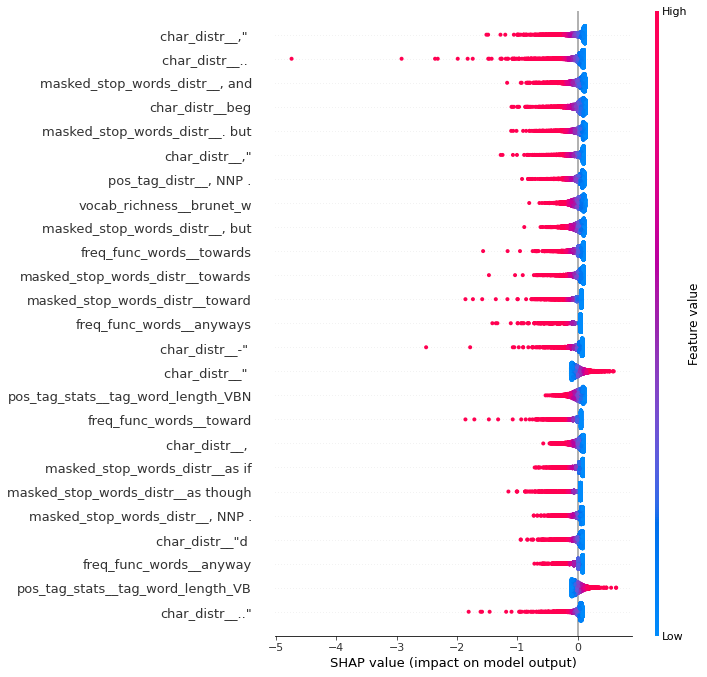

<Figure size 432x288 with 0 Axes>

In [7]:
explainer = shap.LinearExplainer(clf, XX_train_sampled)
shap_values = explainer.shap_values(XX_test_sampled)
plt.clf()
shap.summary_plot(shap_values, XX_test_sampled, feature_names=transformer.get_feature_names(), max_display=25)
plt.tight_layout()

In [8]:
def predict_pan(docs_1, docs_2, clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan):
    docs_merged_1 = [merge_entries(c) for c in docs_1]
    docs_merged_2 = [merge_entries(c) for c in docs_2]
    
    X_1 = scaler_pan.transform(transformer_pan.transform(docs_merged_1).todense())
    X_2 = scaler_pan.transform(transformer_pan.transform(docs_merged_2).todense())
    
    p = clf_pan.predict_proba(secondary_scaler_pan.transform(np.abs(X_1 - X_2)))[:, 1]
    return p

# HUMAN-GPT3

In [10]:
human_docs_1 = []
human_docs_2 = []
ai_docs_1 = []
ai_docs_2 = []

pair_ids = []
for fname in glob.glob(COMPUTED_DATA_PATH + 'human_gpt3_preprocessed.jsonl'):
    with open(fname, 'r') as f:
        for l in f:
            d = json.loads(l)
            human_docs_1.append(d['pair'][0]['human'])
            human_docs_2.append(d['pair'][1]['human'])
            
            ai_docs_1.append(d['pair'][0]['ai'])
            ai_docs_2.append(d['pair'][1]['ai'])
            pair_ids.append(d['id'])
print('Read:', len(human_docs_1))

Read: 93


In [11]:
GROUND_TRUTH_PATH = '../data/pan/pan20-authorship-verification-training-large-truth.jsonl'
ground_truth = {}
with open(GROUND_TRUTH_PATH, 'r') as f:
    for l in f:
        d = json.loads(l)
        ground_truth[d['id']] = d['same']
        
test_docs_1 = []
test_docs_2 = []
labels = []
with open('../temp_data/pan/preprocessed_test.jsonl', 'r') as f:
    for l in f:
#         if np.random.rand() > 0.005:
#             continue
        d = json.loads(l)
        if d['id'] not in pair_ids:
            continue

        test_docs_1.append(d['pair'][0])
        test_docs_2.append(d['pair'][1])
        labels.append(ground_truth[d['id']])
        if len(test_docs_1) == len(pair_ids):
            break
            
print('Read:', len(human_docs_1))

Read: 93


In [12]:
probs_hh = predict_pan(
    human_docs_1, human_docs_2,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = human_docs_1
docs_2 = human_docs_2

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_hh = explainer.shap_values(X_diff)


probs_aa = predict_pan(
    ai_docs_1, ai_docs_2,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = ai_docs_1
docs_2 = ai_docs_2

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_aa = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_aa = explainer.shap_values(X_diff_aa)

probs_ha1 = predict_pan(
    human_docs_1, ai_docs_1,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = human_docs_1
docs_2 = ai_docs_1

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_ha1 = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_ha1 = explainer.shap_values(X_diff_ha1)

In [13]:
shap_summaries_df = pd.DataFrame(
    data=np.vstack([
        np.abs(shap_values.mean(axis=0)),
        np.abs(shap_values_hh.mean(axis=0)), 
        np.abs(shap_values_aa.mean(axis=0)),
        np.abs(shap_values_ha1.mean(axis=0))
        
    ]).T,
    columns=['overall', 'human-human', 'gpt3-gpt3', 'human-gpt3'])
shap_summaries_df['fnames'] = fnames

# Human - ChatGPT

In [14]:
human_docs_1 = []
human_docs_2 = []
ai_docs_1 = []
ai_docs_2 = []

pair_ids = []
for fname in glob.glob(COMPUTED_DATA_PATH + 'human_chatgpt_preprocessed.jsonl'):
    with open(fname, 'r') as f:
        for l in f:
            d = json.loads(l)
            human_docs_1.append(d['pair'][0]['human'])
            human_docs_2.append(d['pair'][1]['human'])
            
            ai_docs_1.append(d['pair'][0]['ai'])
            ai_docs_2.append(d['pair'][1]['ai'])
            pair_ids.append(d['id'])
print('Read:', len(human_docs_1))

Read: 48


In [15]:

probs_aa = predict_pan(
    ai_docs_1, ai_docs_2,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = ai_docs_1
docs_2 = ai_docs_2

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_aa = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_aa = explainer.shap_values(X_diff_aa)

probs_ha1 = predict_pan(
    human_docs_1, ai_docs_1,
    clf, transformer, scaler, secondary_scaler
)
docs_1 = human_docs_1
docs_2 = ai_docs_1

docs_merged_1 = [merge_entries(c) for c in docs_1]
docs_merged_2 = [merge_entries(c) for c in docs_2]

X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

X_diff_ha1 = secondary_scaler.transform(np.abs(X_1 - X_2))
shap_values_ha1 = explainer.shap_values(X_diff_ha1)


shap_summaries_df['chatgpt-chatgpt'] = np.abs(shap_values_aa.mean(axis=0))
shap_summaries_df['human-chatgpt'] = np.abs(shap_values_ha1.mean(axis=0))


In [16]:
shap_summaries_df

,overall,human-human,gpt3-gpt3,human-gpt3,fnames,chatgpt-chatgpt,human-chatgpt
0,0.000056,0.000341,0.000555,0.000336,char_distr__,0.000443,0.000571
1,0.001122,0.002952,0.022461,0.015873,"char_distr__ """,0.013639,0.003127
2,0.000188,0.006875,0.008302,0.007609,"char_distr__ """,0.008095,0.008095
3,0.000219,0.002169,0.004955,0.002318,"char_distr__ "".",0.004955,0.000595
4,0.000263,0.000737,0.007388,0.001928,"char_distr__ ""a",0.003499,0.002383
...,...,...,...,...,...,...,...
22154,0.000086,0.000690,0.000405,0.005161,pos_tag_stats__tag_word_length_VBZ,0.000004,0.004376
22155,0.000011,0.001054,0.000627,0.001403,pos_tag_stats__tag_word_length_WDT,0.002623,0.001879
22156,0.000030,0.001115,0.002045,0.001409,pos_tag_stats__tag_word_length_WP,0.002114,0.000586
22157,0.001628,0.015016,0.019747,0.017381,pos_tag_stats__tag_word_length_WP$,0.010653,0.015237


In [18]:
shap_summaries_df.columns

Index(['overall', 'human-human', 'gpt3-gpt3', 'human-gpt3', 'fnames',
       'chatgpt-chatgpt', 'human-chatgpt'],
      dtype='object')

-0.375
-0.125
0.125


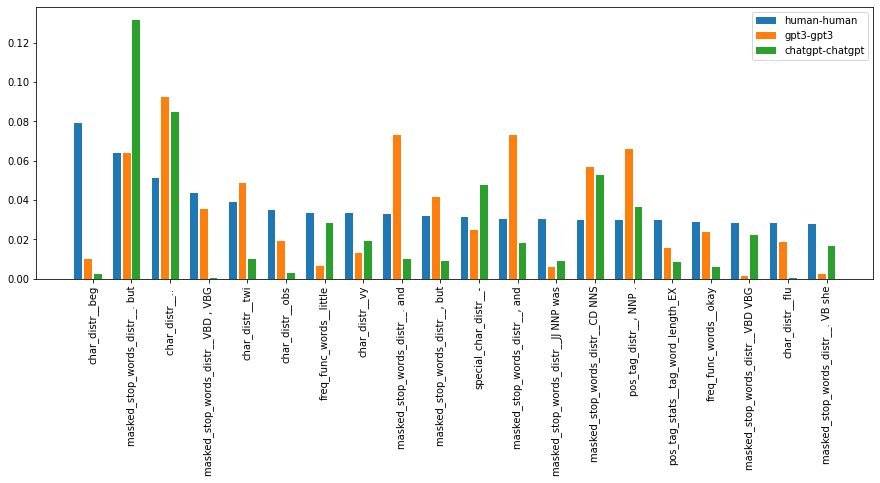

In [31]:
shap_summaries_selected_df = shap_summaries_df.sort_values('human-human', ascending=False).head(20)
x = np.arange(len(shap_summaries_selected_df))
fig, ax = plt.subplots( figsize=(15, 5))
# cols = ['human-human', 'gpt3-gpt3', 'human-gpt3', 'chatgpt-chatgpt', 'human-chatgpt']
cols = ['human-human', 'gpt3-gpt3',  'chatgpt-chatgpt']
for i, c in enumerate(cols):
    width = 1/(len(cols)+1)
    offset = width * i - (width*len(cols)/2)
    print(offset)
    ax.bar(x + offset, shap_summaries_selected_df[c], width=0.2, label=c)

    
ax.set_xticks(x)
ax.set_xticklabels(labels=shap_summaries_selected_df['fnames'], rotation=90)
ax.legend()
plt.show()

In [32]:
shap_summaries_df.to_csv('shap_summaries.csv')

In [24]:
1/(len(cols)

0.2

In [27]:
width

0.16666666666666666